In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.utils import grid
from torch_geometric.data import Data
import torch_geometric.nn as gnn
from pyhdf.SD import SD, SDC

In [2]:
def read_hdf(hdf_path, dataset_names):
    f = SD(hdf_path, SDC.READ)
    datasets = []
    for dataset_name in dataset_names:
        datasets.append(f.select(dataset_name).get())
    return datasets

In [20]:
def spherical_grid_edges(height, width):
    # Create grid edges first (without periodic boundary conditions)
    edge_index, _ = grid(height=height, width=width)
    
    # Periodic boundary for horizontal edges (right-left wrapping)
    horizontal_edges = []
    for i in range(height):
        left = i * width
        right = (i + 1) * width - 1
        horizontal_edges.append((right, left))  # Connect right edge to left edge
    
    # Convert horizontal_edges to a tensor
    horizontal_edges = torch.tensor(horizontal_edges).t().long()
    
    # Concatenate the original edge index with the new periodic horizontal edges
    edge_index = torch.cat([edge_index, horizontal_edges], dim=1)
    
    return edge_index

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, file_paths):
        """
        Args:
            file_paths (list): List of paths to Br files.
        """
        self.edge_index = spherical_grid_edges(101, 101)
        cubes = []
        for file_path in file_paths:
            arr, i, j, k = read_hdf(
                file_path, ["Data-Set-2", "fakeDim0", "fakeDim1", "fakeDim2"]
            )
            arr = np.transpose(arr, (2, 1, 0))
            k = np.expand_dims(np.expand_dims(k, axis=-1), axis=-1)
            arr = arr * (k**2)
            cubes.append(arr)
        cubes = np.stack(cubes, axis=0)
        self.min_, self.max_ = np.min(cubes), np.max(cubes)
        cubes = (cubes - self.min_) / (self.max_ - self.min_)
        self.cubes = cubes

    def __len__(self):
        return self.cubes.shape[0]

    def get_graph_data(self, data):
        if (data.dtype==torch.float32):
            x = data.flatten().unsqueeze(-1)
        else:
            x = torch.tensor(data.flatten(), dtype=torch.float32).unsqueeze(-1)
        return Data(x=x, edge_index=self.edge_index)

    def __getitem__(self, idx):
        slices = []
        cube = self.cubes[idx]
        for k in range(self.num_time_steps):
            data = self.get_graph_data(cube[k])
            slices.append(data)
        return slices, cube[1:]

In [30]:
dataset = CustomDataset(['/Users/reza/Career/DMLab/SURROGATE/Data/pfss/2024-12-15/br.hdf'], 100)

In [31]:
edge_index = spherical_grid_edges(101, 101)

In [32]:
class GNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNNModel, self).__init__()
        self.conv1 = gnn.GCNConv(input_dim, hidden_dim)
        self.conv2 = gnn.GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.sigmoid(self.conv2(x, edge_index))
        return x

In [35]:
model = GNNModel(1, 128, 1)

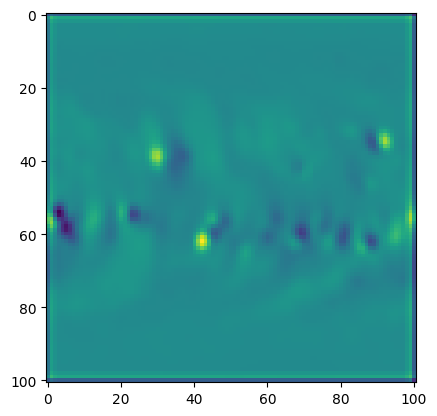

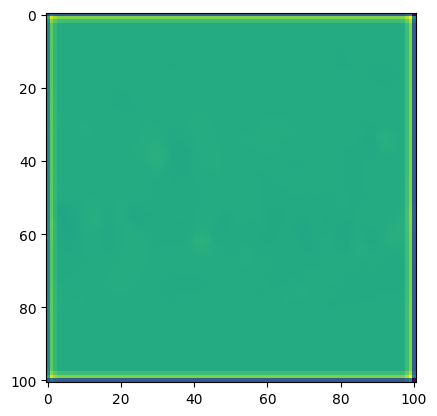

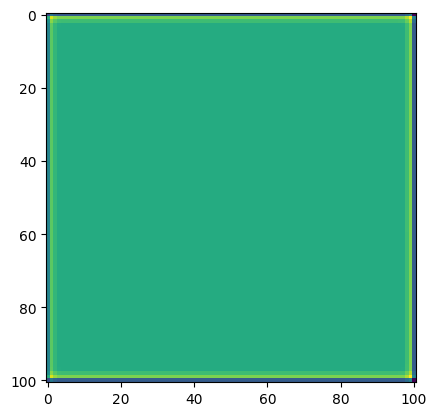

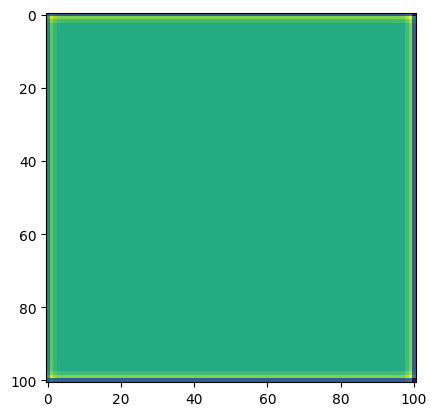

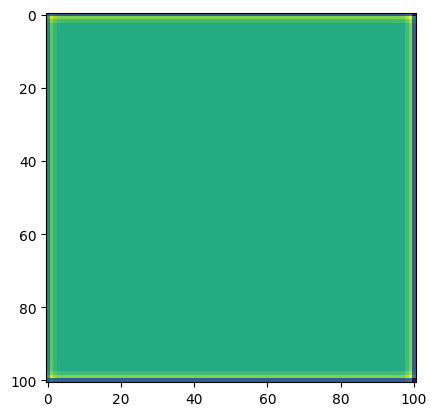

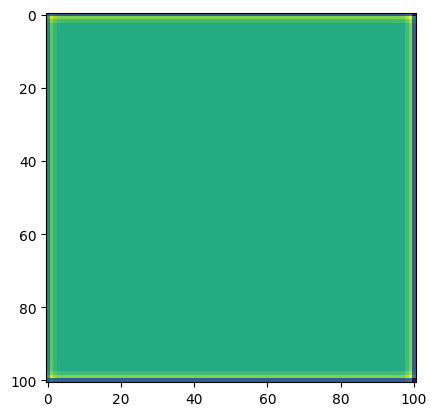

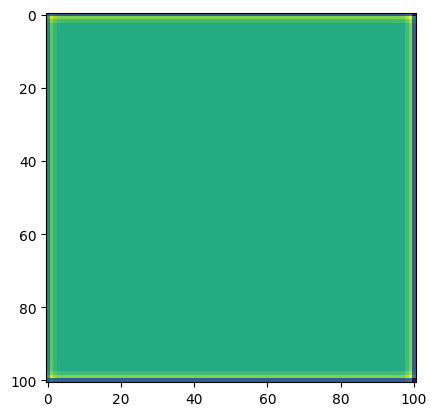

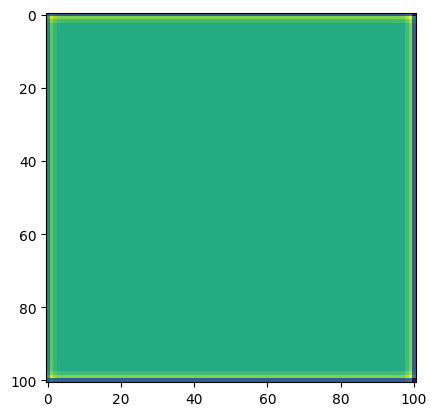

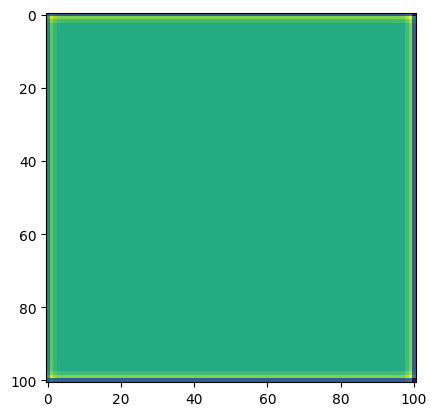

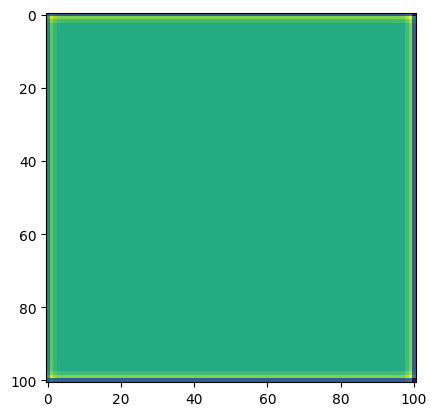

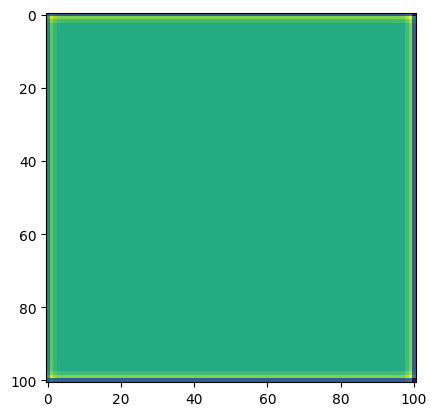

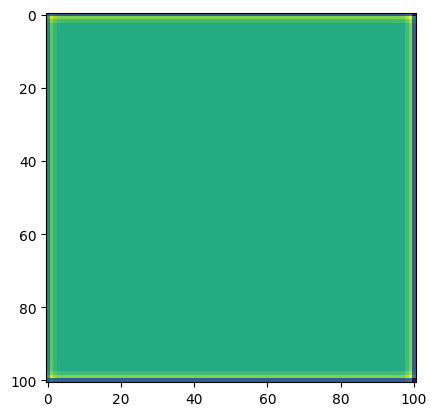

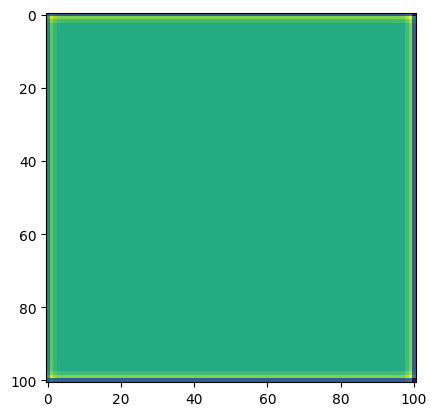

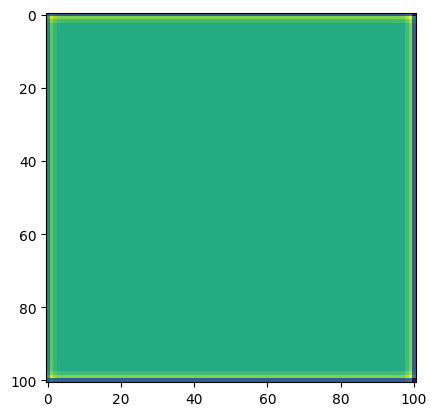

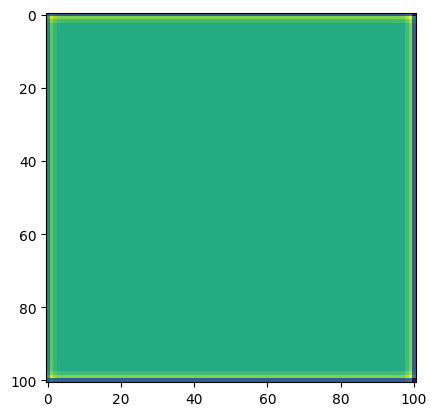

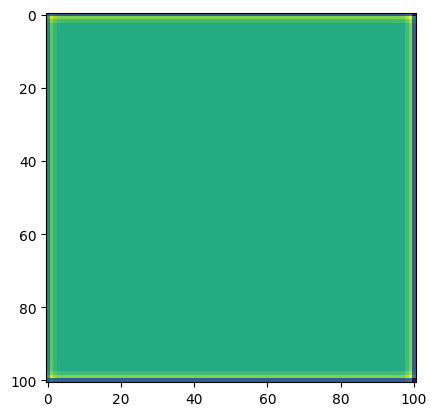

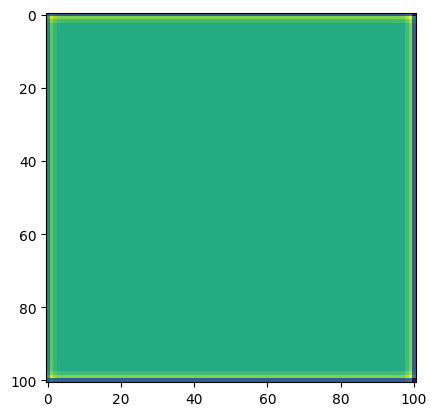

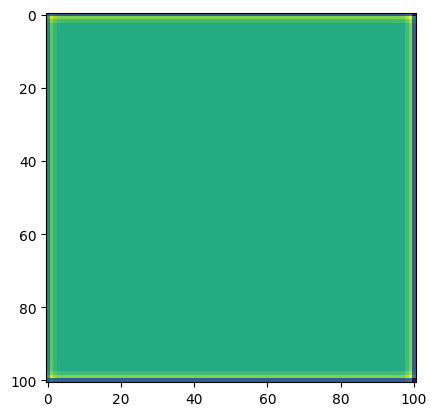

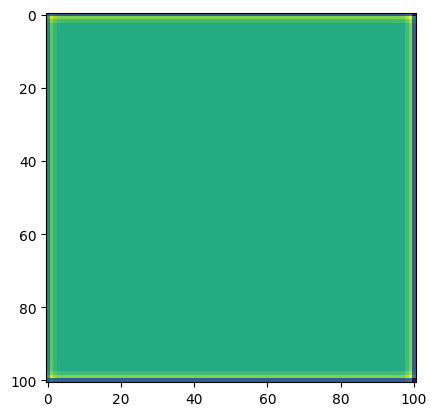

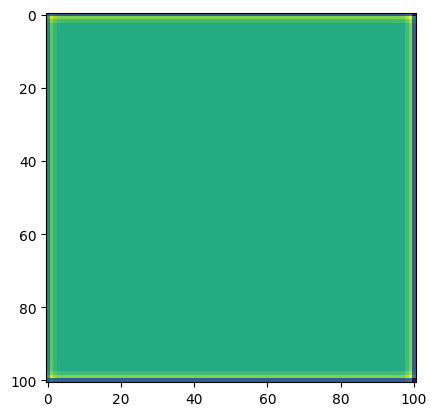

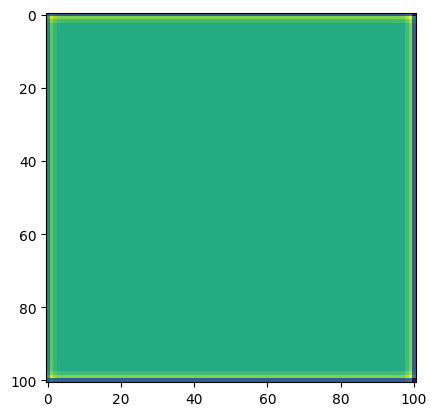

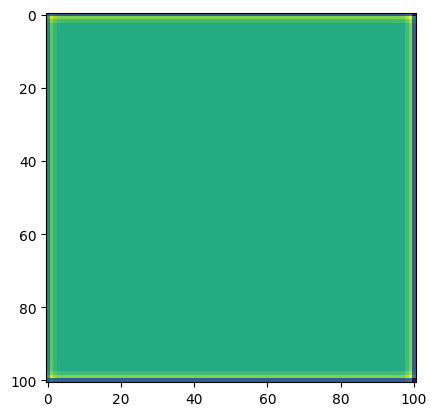

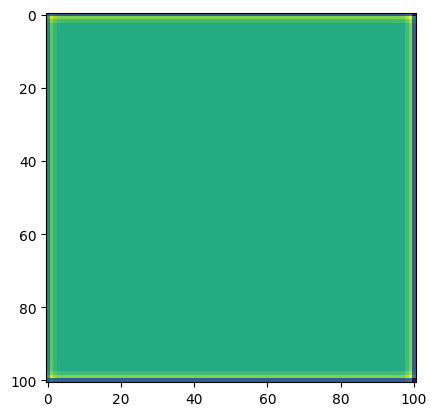

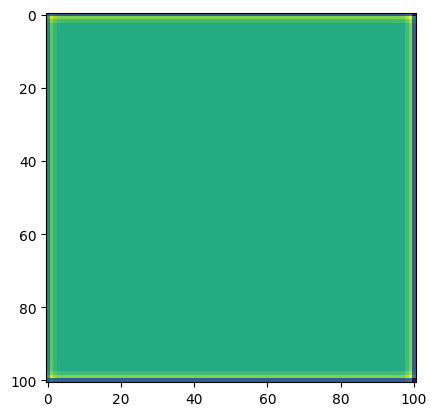

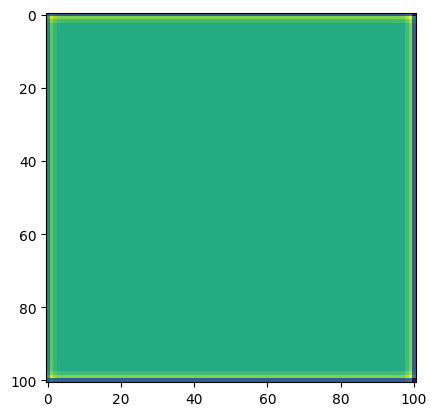

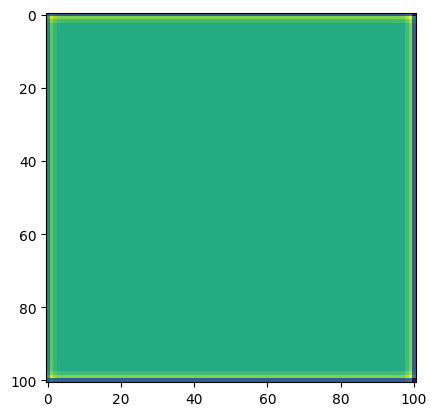

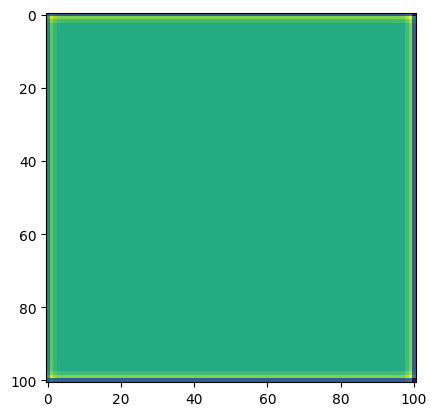

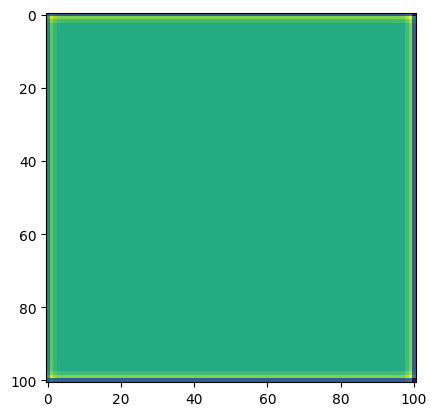

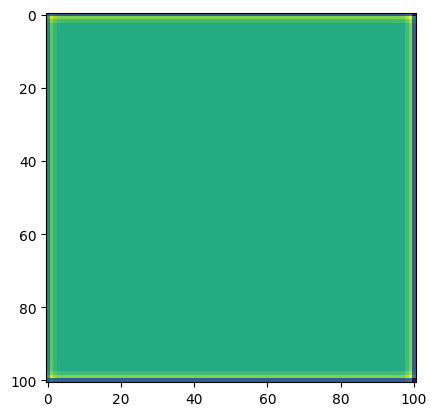

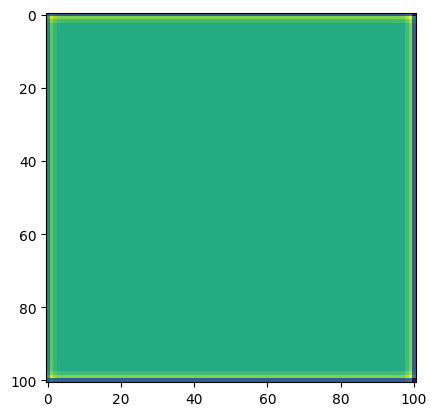

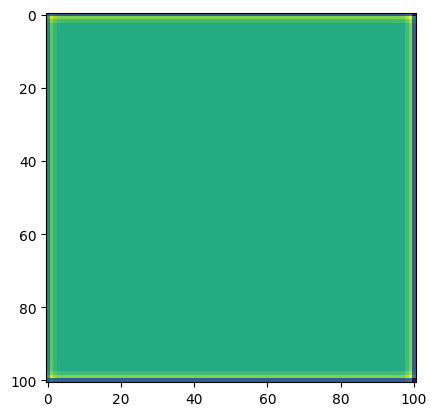

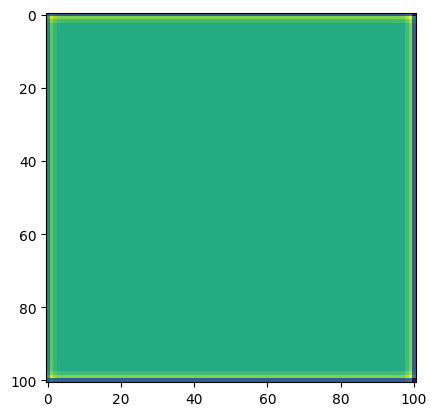

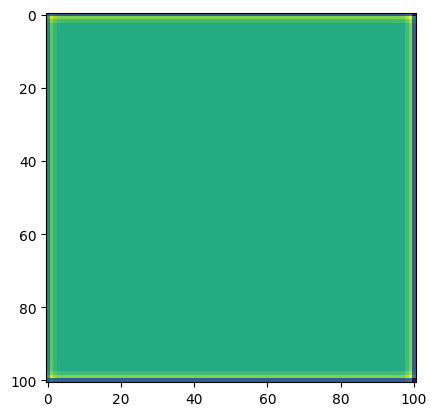

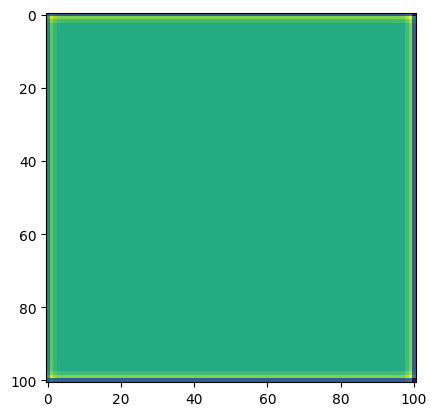

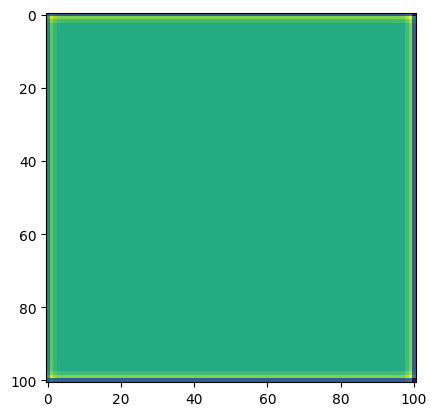

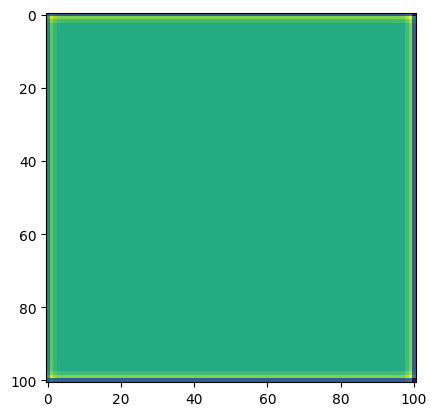

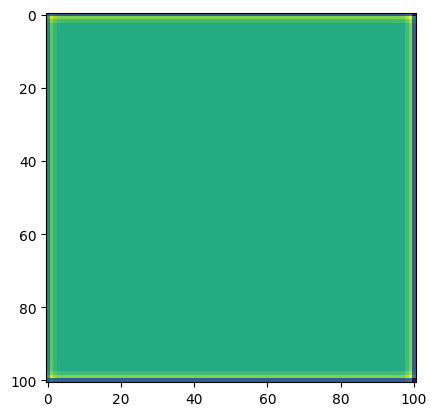

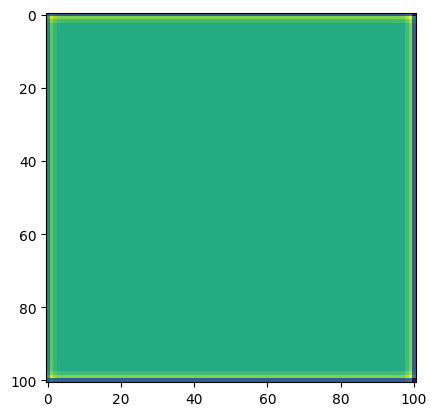

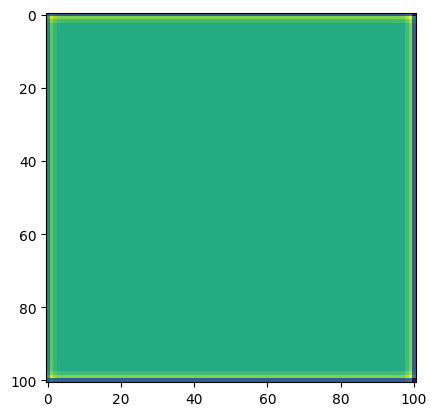

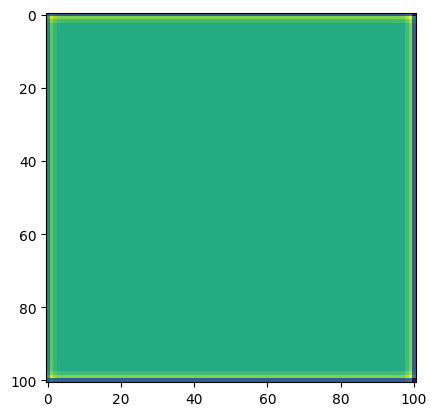

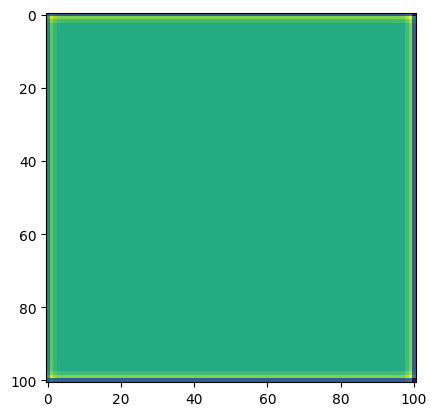

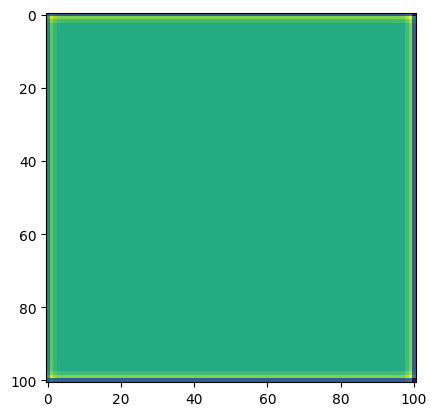

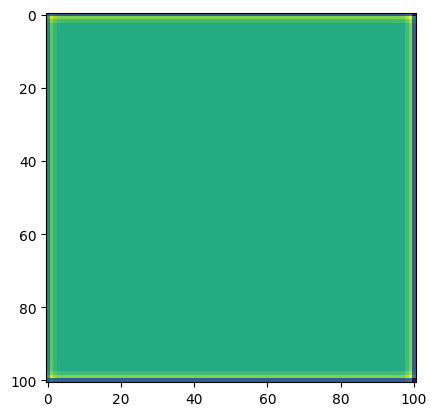

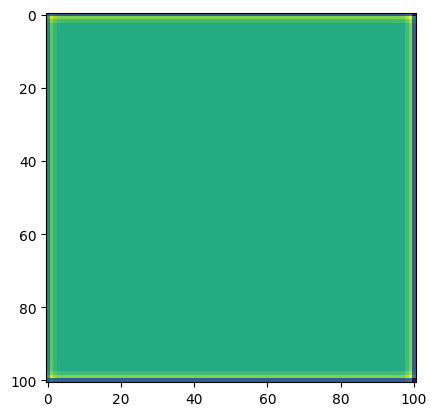

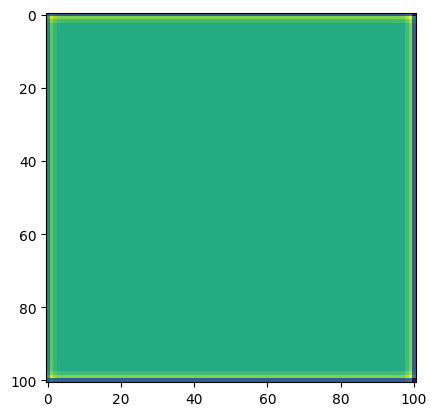

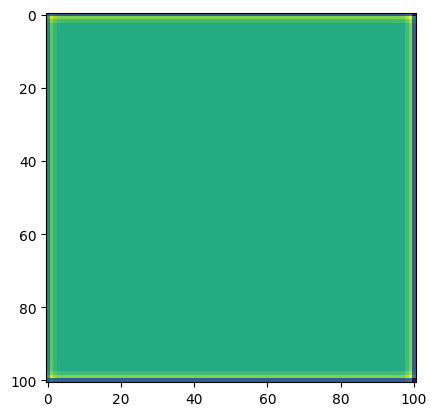

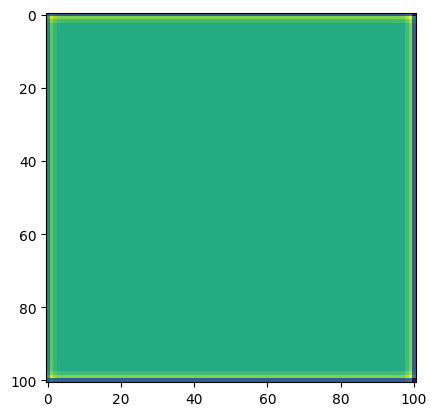

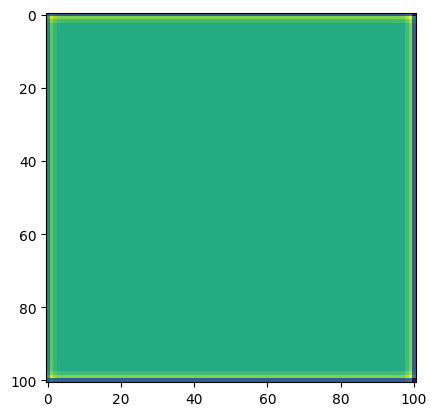

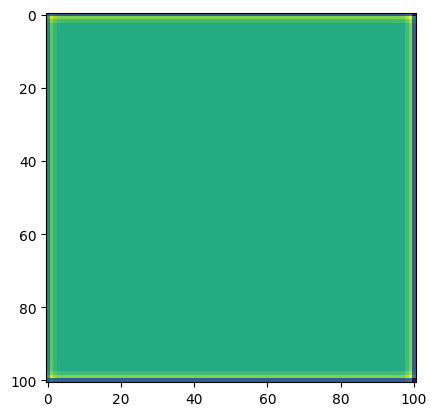

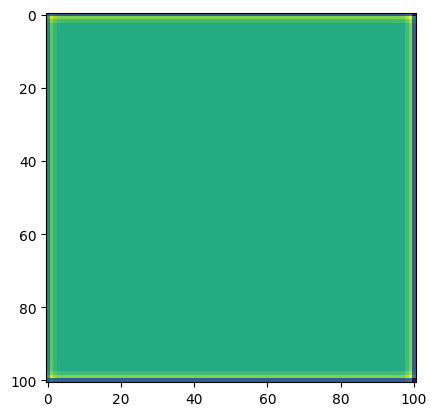

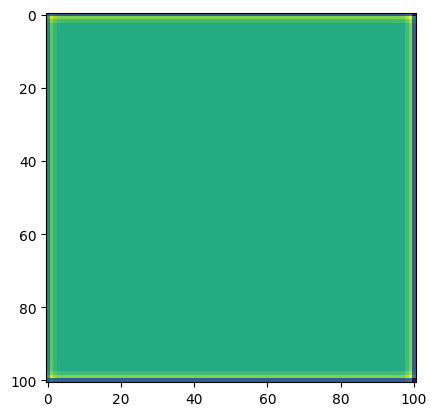

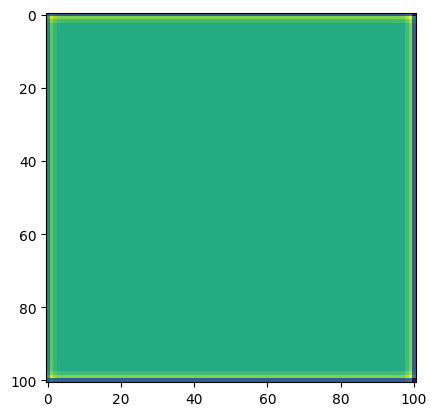

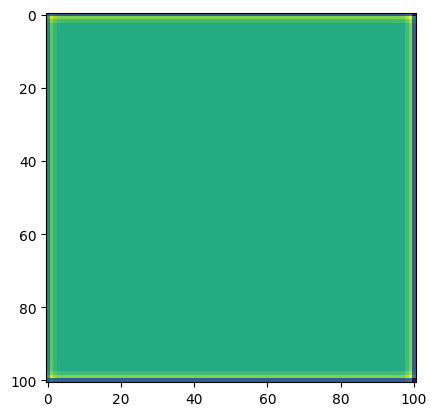

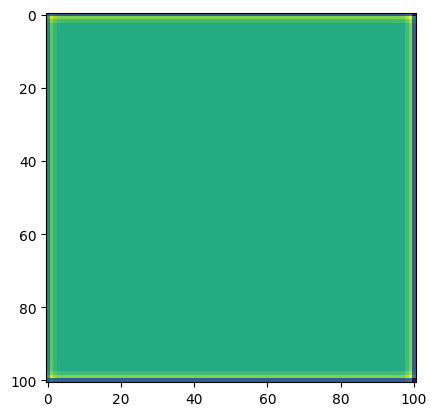

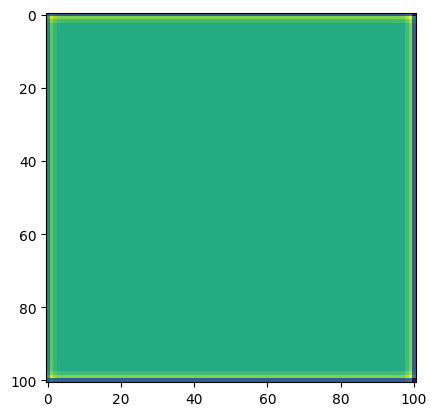

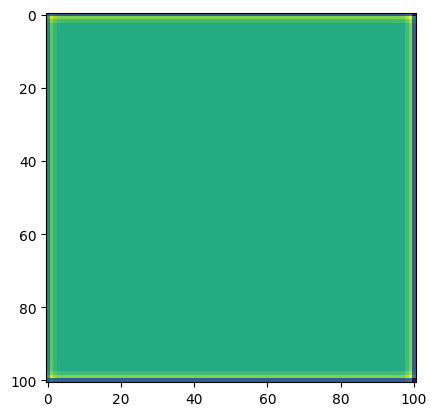

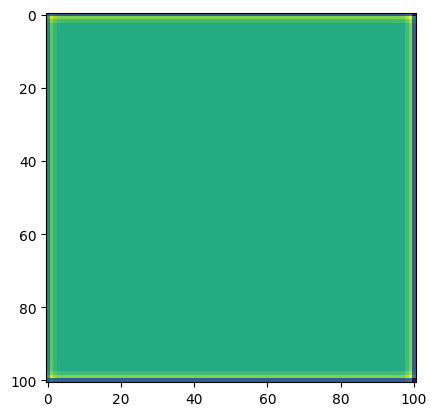

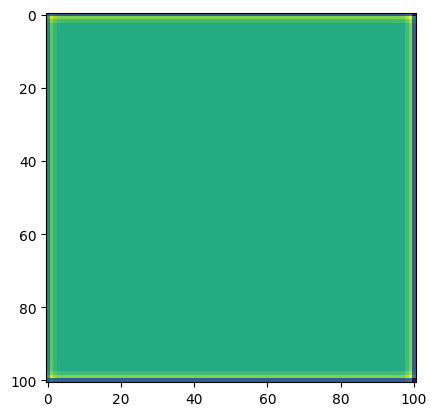

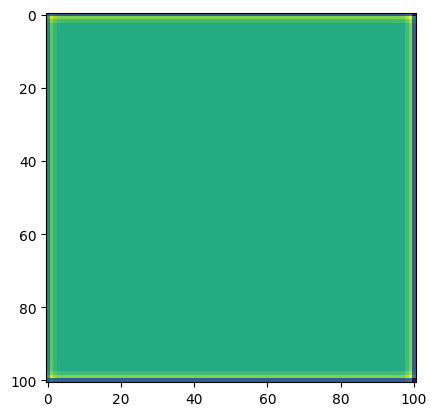

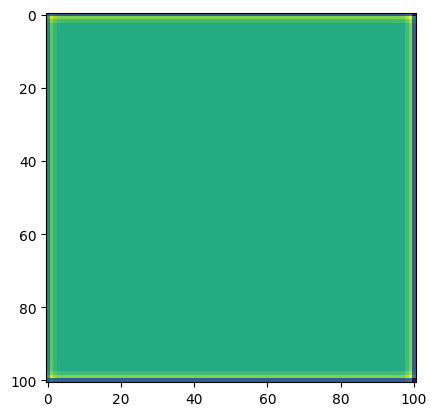

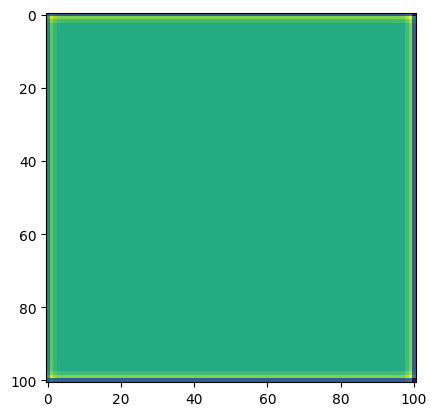

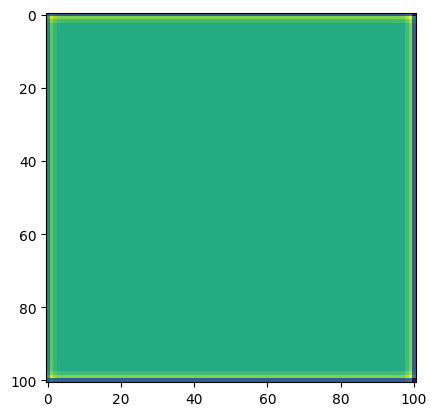

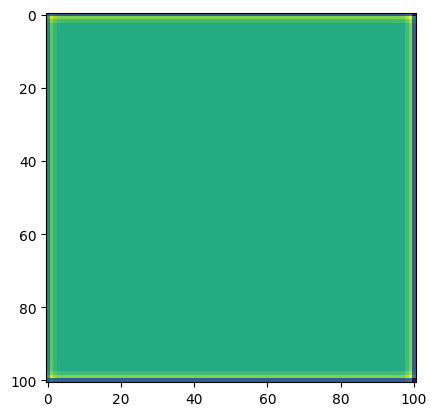

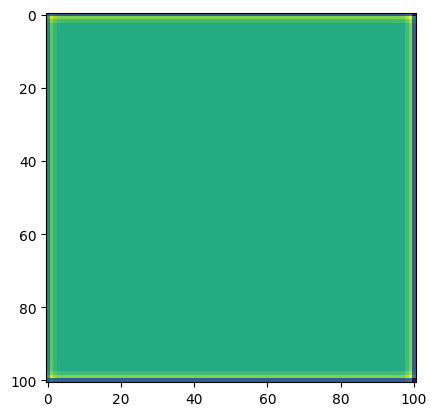

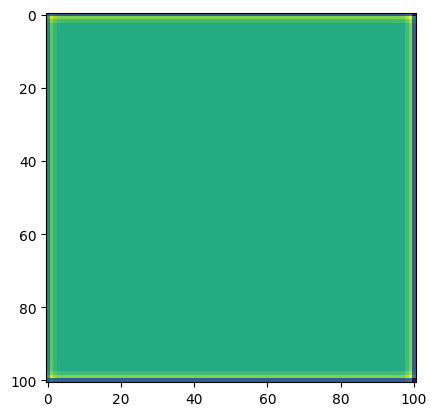

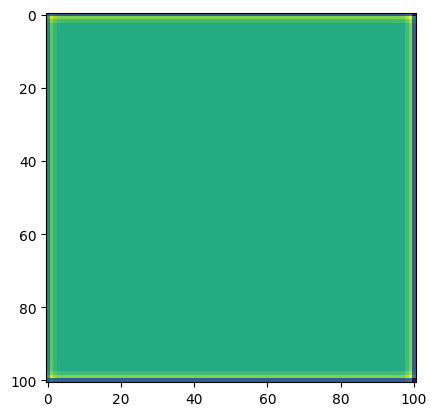

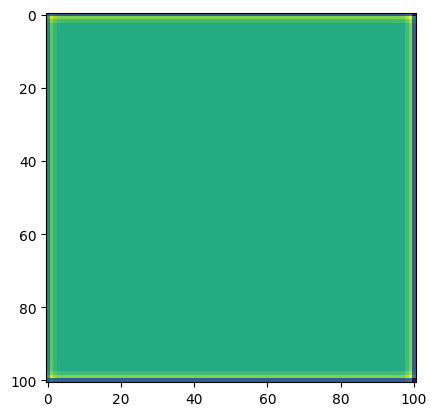

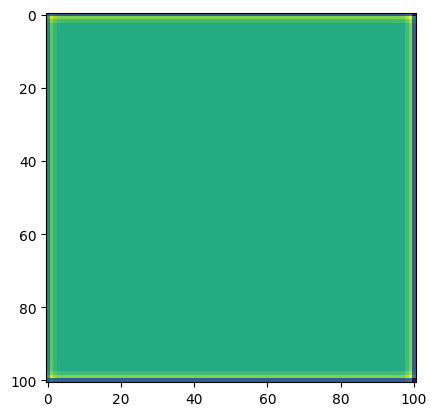

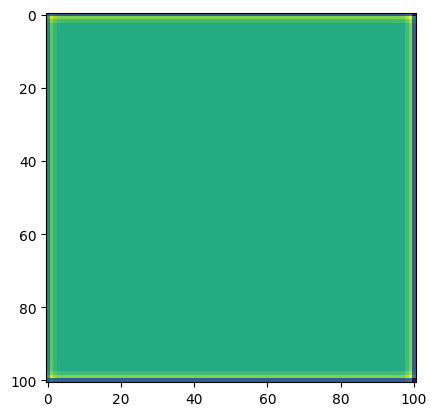

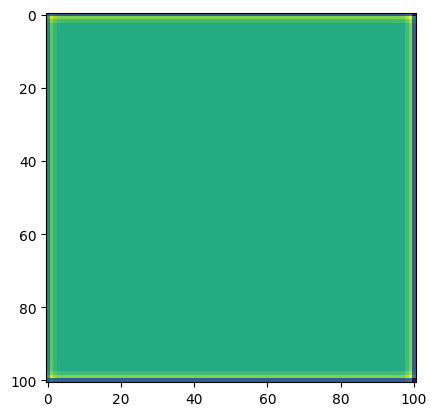

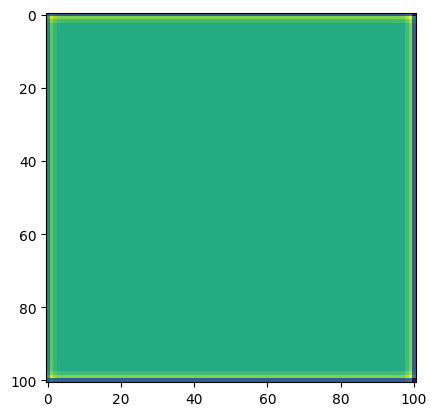

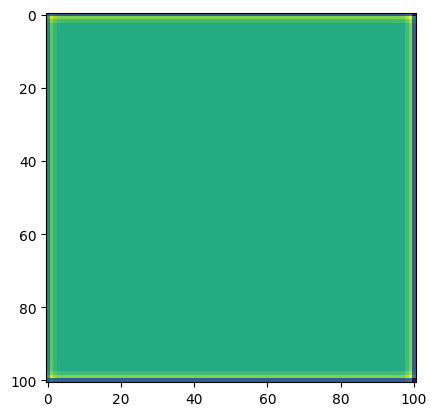

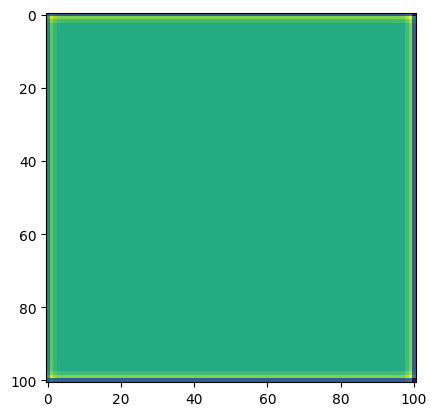

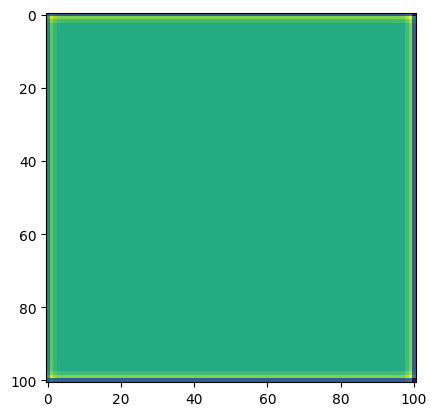

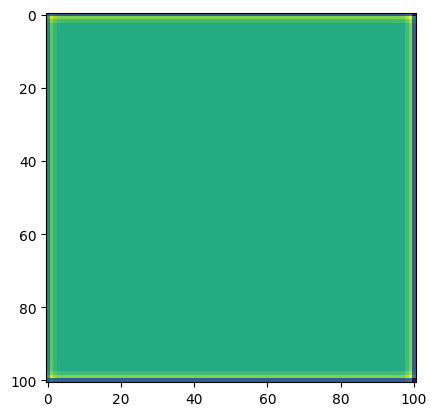

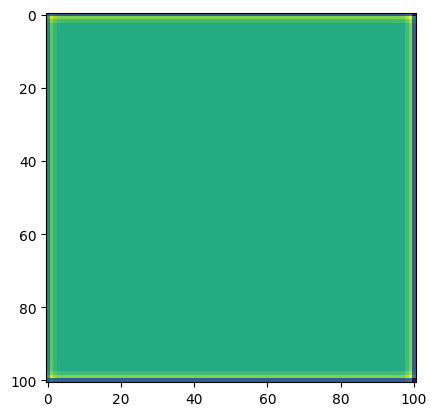

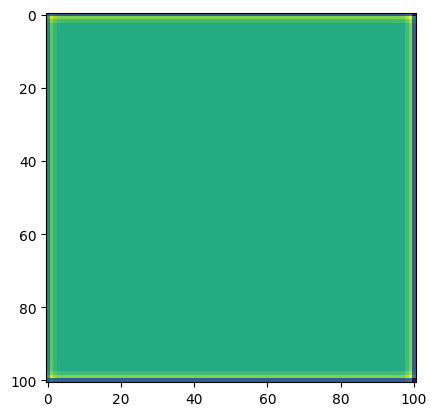

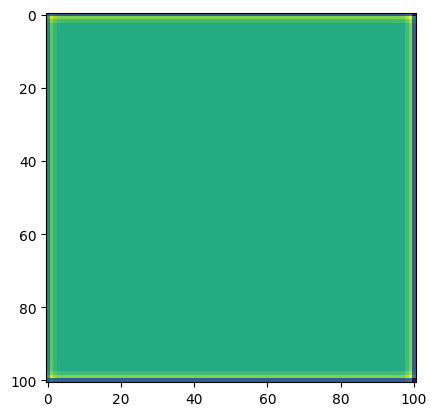

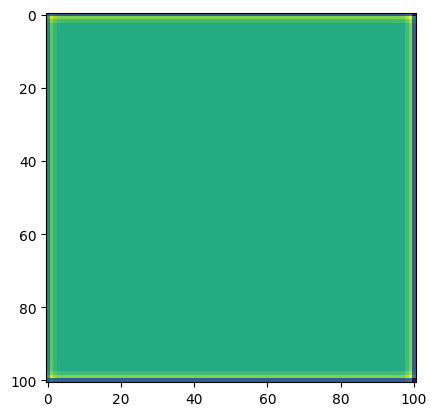

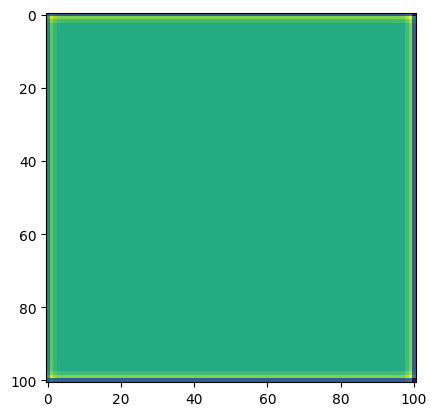

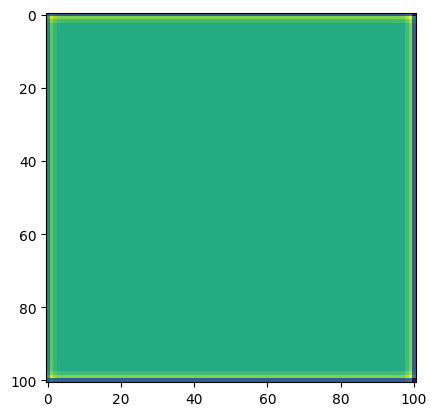

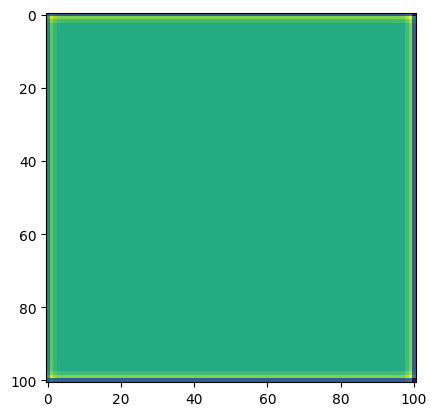

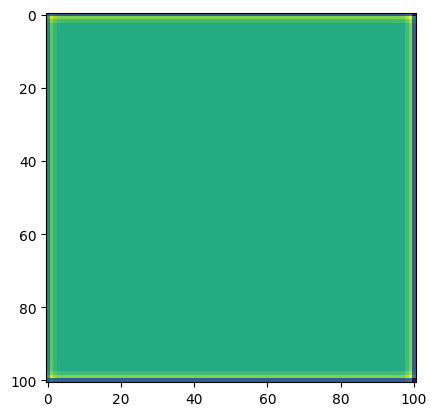

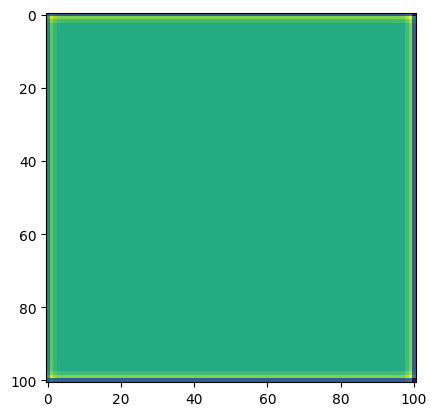

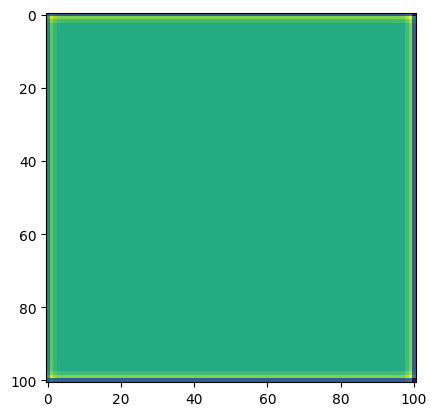

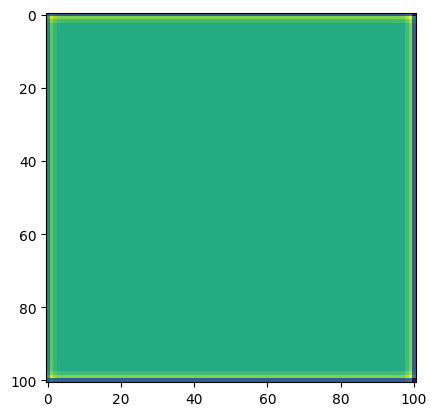

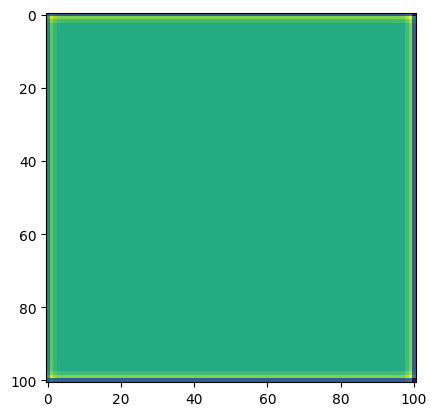

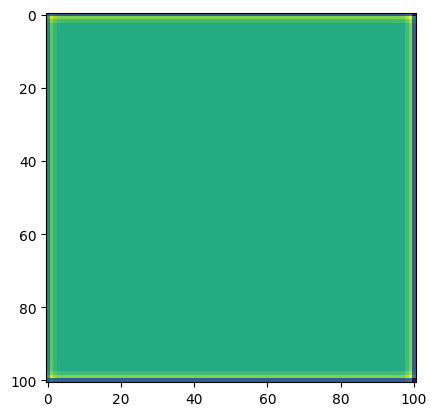

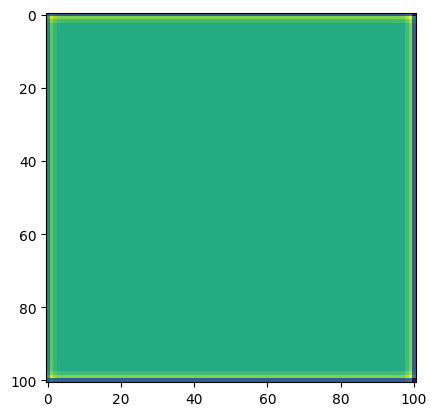

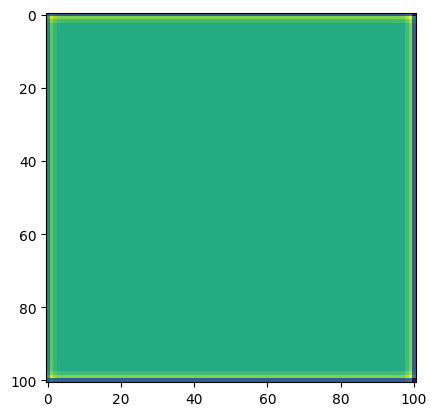

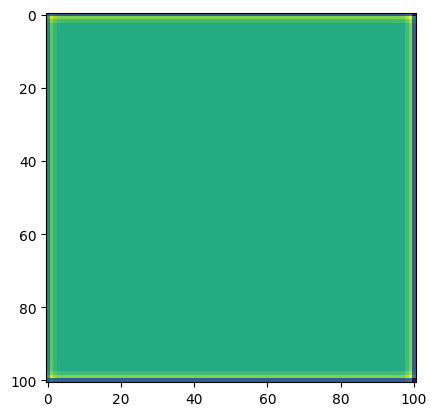

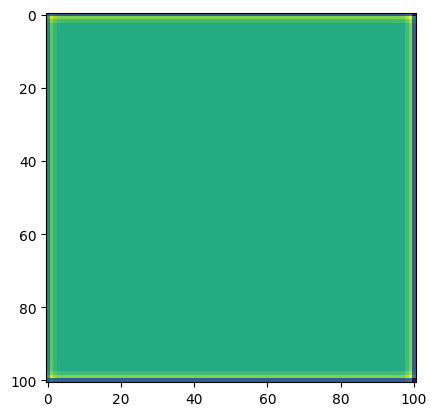

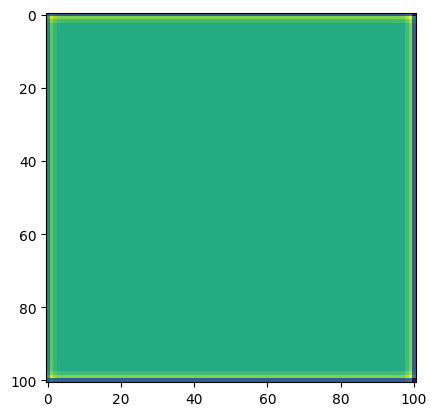

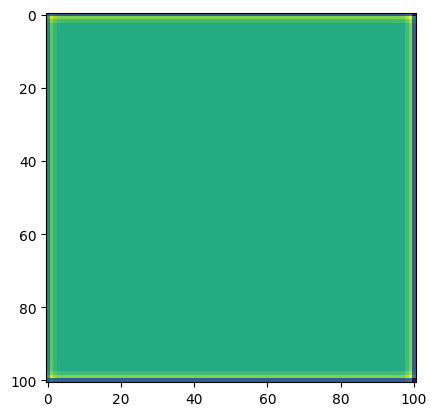

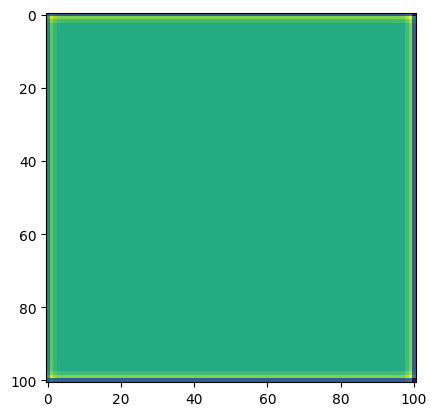

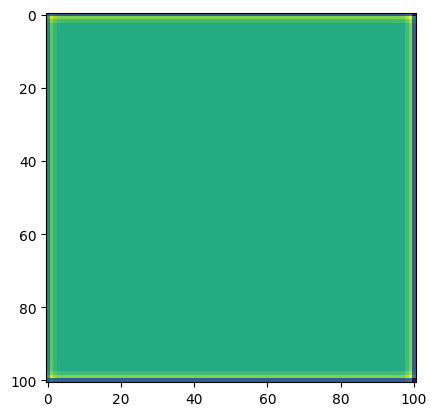

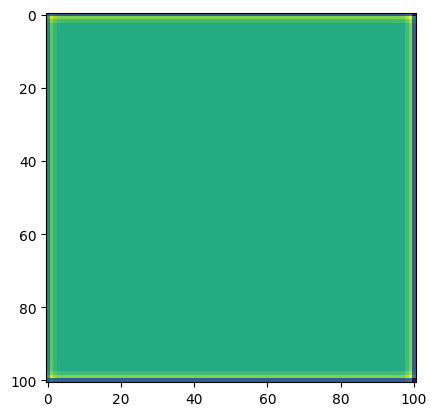

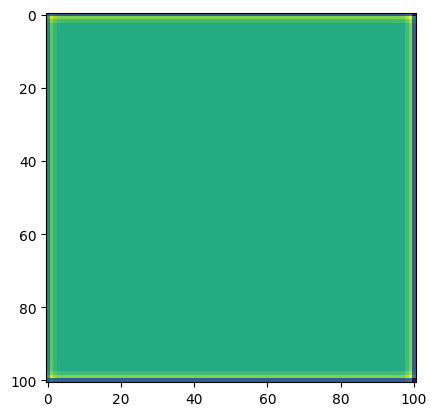

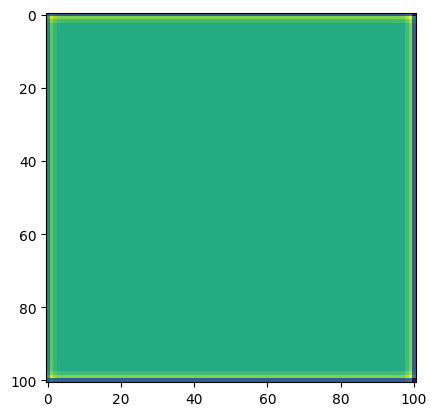

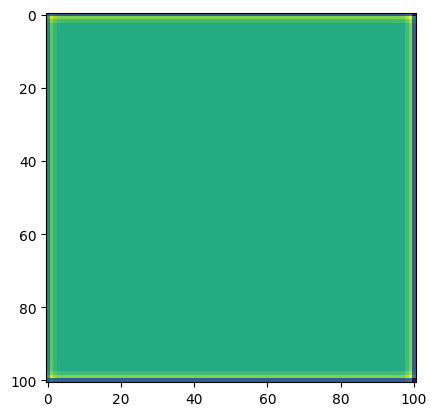

In [36]:
for slices, cube in dataset:
    x = slices[0]
    for k in range(100):
        x = model(x).reshape(101, 101)
        plt.imshow(x.detach().numpy())
        plt.show()
        x = dataset.get_graph_data(x)